<a href="https://colab.research.google.com/github/anujpanwarma2024/RLMidTermProject/blob/main/RLEndTermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

# Phase 1: Load & clean the tape, with row 6 as header
url = (
    "https://raw.githubusercontent.com/"
    "anujpanwarma2024/RLMidTermProject/main/"
    "Clean%20Untitled%20spreadsheet%20-%20Data%20Tape.csv"
)
df = pd.read_csv(url, skiprows=5)                  # skip rows 0–4
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]  # drop empty cols

# Extract interest rate from “Loan Product”
df['InterestRatePct'] = (
    df['Loan Product'].astype(str)
      .str.extract(r'(\d+\.?\d*)%\s*$', expand=False)
      .astype(float)
)

# Parse Qualifying DTI as decimal
df['Qualifying DTI'] = (
    df['Qualifying DTI'].astype(str)
      .str.rstrip('%').replace('', np.nan).astype(float)
)

# Coerce other numeric fields and drop NaNs
for c in ['DPD','Loan Age','Original Loan Amount','Current Outstanding Principal']:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df.dropna(subset=['InterestRatePct','Qualifying DTI','DPD','Loan Age'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Context extractor
def extract_context(row):
    return np.array([row['InterestRatePct'], row['DPD'], row['Loan Age']], dtype=np.float32)

print("DataFrame ready with", len(df), "rows.")


DataFrame ready with 240 rows.


In [ ]:
# Immediately after dropping NaNs and resetting index:
assert not df['InterestRatePct'].isna().any(), "Found NaN InterestRatePct"
assert not df['Qualifying DTI'].isna().any(),   "Found NaN Qualifying DTI"
assert not df['DPD'].isna().any(),              "Found NaN DPD"
assert not df['Loan Age'].isna().any(),         "Found NaN Loan Age"


In [54]:
# Hyperparameters
NUM_EPISODES   = 200
EP_LEN         = 4       # quarters per episode
ALPHA          = 0.005     # policy LR
SIGMA          = 0.2      # action noise
BETA           = 0.1     # baseline LR
PENALTY_SCALE  = 0.01    # DTI‐penalty coefficient
DTI_THRESH     = 0.20     # 20% threshold


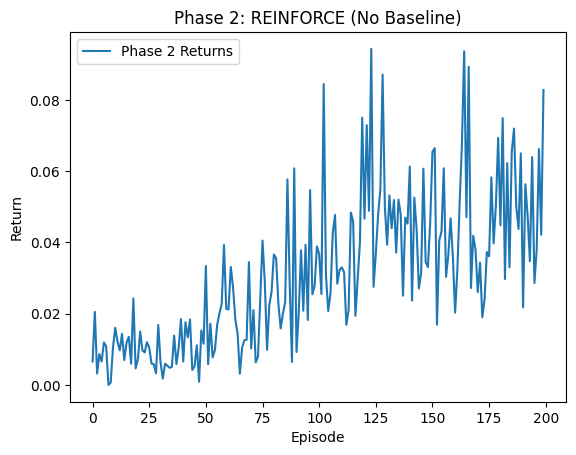

Phase 2 Mean Return: 0.031


In [55]:
# === Phase 2: Base Continuous REINFORCE ===

import numpy as np
import matplotlib.pyplot as plt

# (Re‐use df and extract_context from Phase 1 setup)

# Hyperparameters
num_episodes = 200
alpha = 0.005    # learning rate
sigma = 0.2       # policy std‐dev

# Initialize policy weights
w2 = np.zeros(3, dtype=np.float32)

# Storage for episode returns
returns2 = []

for ep in range(num_episodes):
    xs, actions, rewards = [], [], []

    # Sample an initial loan and context
    row = df.sample(1).iloc[0]
    x = extract_context(row)

    # Rollout one episode (4 steps/quarters)
    for t in range(4):
        mu = w2.dot(x)
        a = np.clip(np.random.normal(mu, sigma), 0, 1)

        # Compute reward = allocation × interest rate
        r = a * (row['InterestRatePct'] / 100.0)

        xs.append(x)
        actions.append(a)
        rewards.append(r)

        # Move to next loan/context
        row = df.sample(1).iloc[0]
        x = extract_context(row)

    # Monte Carlo return
    G = sum(rewards)
    returns2.append(G)

    # REINFORCE update
    for x_t, a_t in zip(xs, actions):
        grad_logp = ((a_t - w2.dot(x_t)) / sigma**2) * x_t
        w2 += alpha * G * grad_logp

# Plot Phase 2 learning curve
plt.plot(returns2, label='Phase 2 Returns')
plt.title("Phase 2: REINFORCE (No Baseline)")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

print(f"Phase 2 Mean Return: {np.mean(returns2):.3f}")


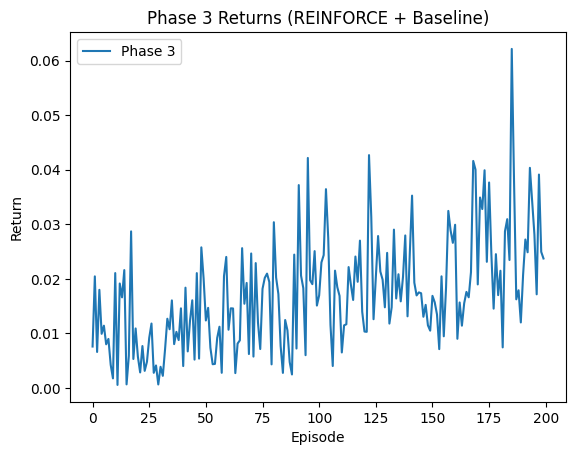

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
num_episodes = 200
alpha = 0.005
sigma = 0.2
beta = 0.1

# Initialize
w3 = np.zeros(3, dtype=np.float32)
b3 = 0.0
returns3 = []

# Phase 3 loop
for ep in range(num_episodes):
    xs, acts, rs = [], [], []
    row = df.sample(1).iloc[0]
    x = extract_context(row)
    for t in range(4):
        mu = w3.dot(x)
        a = np.clip(np.random.normal(mu, sigma), 0, 1)
        # Reward only (no punishment)
        r = a * (row['InterestRatePct']/100.0)
        xs.append(x); acts.append(a); rs.append(r)
        row = df.sample(1).iloc[0]
        x = extract_context(row)
    G = sum(rs)
    returns3.append(G)
    A = G - b3
    for x_t, a_t in zip(xs, acts):
        grad_logp = ((a_t - w3.dot(x_t)) / sigma**2) * x_t
        w3 += alpha * A * grad_logp
    b3 = (1 - beta) * b3 + beta * G

# Plot
plt.plot(returns3, label='Phase 3')
plt.title("Phase 3 Returns (REINFORCE + Baseline)")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend()
plt.show()


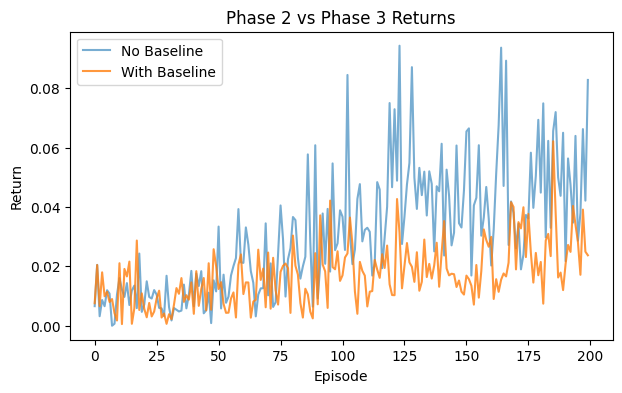

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(returns2, label='No Baseline', alpha=0.6)
plt.plot(returns3, label='With Baseline', alpha=0.8)
plt.title("Phase 2 vs Phase 3 Returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()


Phase 4 5% VaR: -4.250,   5% ES: -4.999


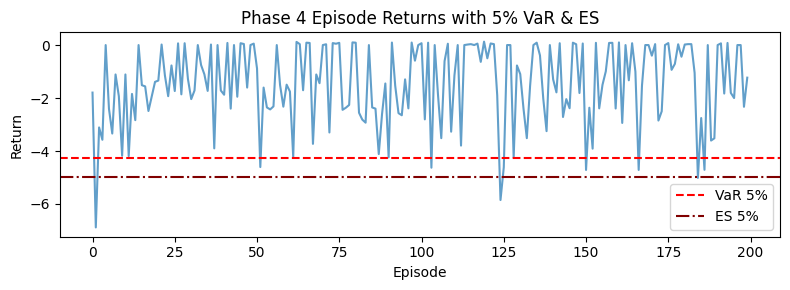

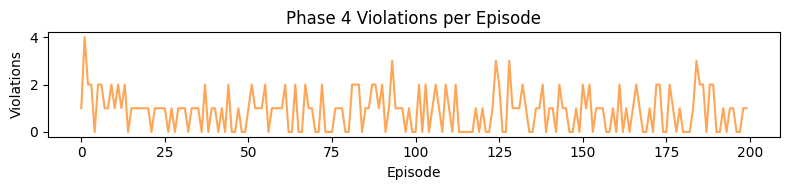

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# === Phase 4: REINFORCE + Baseline + DTI Penalty + VaR/ES ===

# Hyperparameters
NUM_EPISODES   = 200
EP_LEN         = 4
ALPHA          = 0.005
SIGMA          = 0.2
BETA           = 0.1
PENALTY_SCALE  = 0.01
DTI_THRESH     = 0.20

# Assumes df, extract_context(row), and step4(x,a,row) are already defined

# Initialize weights & baseline
w4 = np.zeros(3, dtype=np.float32)
b4 = 0.0

# Storage
returns4    = []
violations4 = []

# Training loop
for ep in range(NUM_EPISODES):
    xs, acts, rs = [], [], []
    vio_cnt = 0

    row = df.sample(1).iloc[0]
    x   = extract_context(row)

    for t in range(EP_LEN):
        mu = w4.dot(x)
        a  = np.clip(np.random.normal(mu, SIGMA), 0, 1)
        x, r, vio = step4(x, a, row)
        if np.isnan(r): r = 0.0

        xs.append(x); acts.append(a); rs.append(r)
        vio_cnt += int(vio)
        row = df.sample(1).iloc[0]

    G = sum(rs)
    returns4.append(G)
    violations4.append(vio_cnt)

    # REINFORCE update with baseline
    A = G - b4
    for x_t, a_t in zip(xs, acts):
        grad = ((a_t - w4.dot(x_t)) / SIGMA**2) * x_t
        w4 += ALPHA * A * grad
    b4 = (1 - BETA) * b4 + BETA * G

# — Compute 5% VaR & ES on returns4 —
def var_es(returns, alpha=0.05):
    sorted_r = np.sort(returns)
    n        = len(sorted_r)
    k        = int(np.ceil(alpha * n))
    VaR      = sorted_r[k-1]
    ES       = sorted_r[:k].mean()
    return VaR, ES

VaR_05, ES_05 = var_es(np.array(returns4), alpha=0.05)
print(f"Phase 4 5% VaR: {VaR_05:.3f},   5% ES: {ES_05:.3f}")

# — Plot Phase 4 Returns vs. Episodes —
plt.figure(figsize=(8,3))
plt.plot(returns4, color='tab:blue', alpha=0.7)
plt.axhline(VaR_05, color='red',   linestyle='--', label='VaR 5%')
plt.axhline(ES_05,  color='maroon', linestyle='-.', label='ES 5%')
plt.title("Phase 4 Episode Returns with 5% VaR & ES")
plt.xlabel("Episode"); plt.ylabel("Return")
plt.legend(); plt.tight_layout()
plt.show()

# — Plot Violations per Episode —
plt.figure(figsize=(8,2))
plt.plot(violations4, color='tab:orange', alpha=0.7)
plt.title("Phase 4 Violations per Episode")
plt.xlabel("Episode"); plt.ylabel("Violations")
plt.tight_layout()
plt.show()


On‐Policy MC Estimate: 0.0216 ± 0.0004


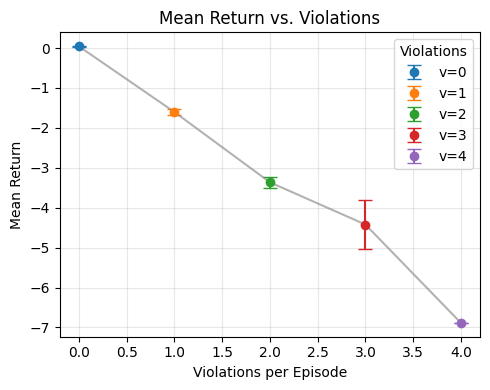

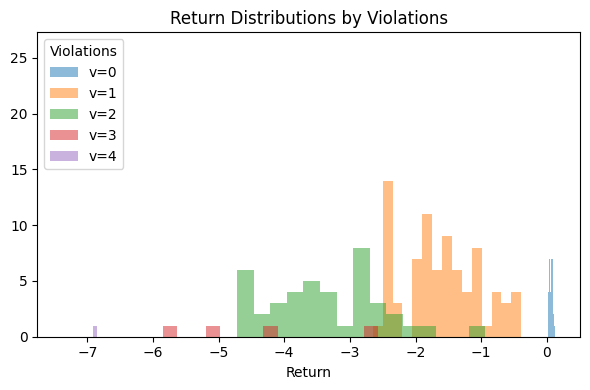

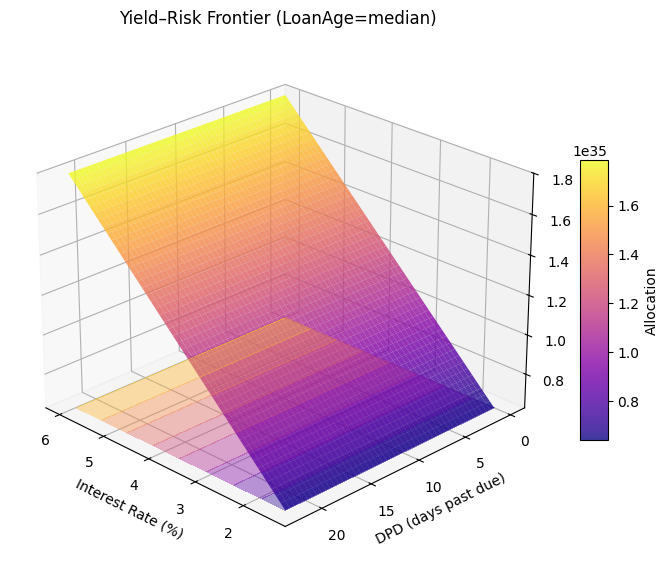

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

# === 1) On‐Policy Monte Carlo + 95% CI ===
mc_samples = []
for _ in range(1000):
    row = df.sample(1).iloc[0]
    x   = extract_context(row)
    mu  = w4.dot(x)
    a   = np.clip(np.random.normal(mu, SIGMA), 0, 1)
    r   = a * (row['InterestRatePct']/100.0)
    mc_samples.append(r)
mc = np.array(mc_samples)
mean_return = mc.mean()
ci95        = 1.96 * mc.std() / np.sqrt(len(mc))
print(f"On‐Policy MC Estimate: {mean_return:.4f} ± {ci95:.4f}")

# === 2) Mean Return vs. Violations (Error Bars) ===
v_counts = np.array(violations4)
rts      = np.array(returns4)
unique_vs = np.unique(v_counts)
means    = [rts[v_counts==v].mean() for v in unique_vs]
sems     = [rts[v_counts==v].std()/np.sqrt((v_counts==v).sum()) for v in unique_vs]

colors = plt.cm.tab10.colors
plt.figure(figsize=(5,4))
for i, v in enumerate(unique_vs):
    plt.errorbar(v, means[i], yerr=sems[i],
                 fmt='o', color=colors[i%10], capsize=5, label=f"v={v}")
plt.plot(unique_vs, means, '-', color='gray', alpha=0.6)
plt.title("Mean Return vs. Violations")
plt.xlabel("Violations per Episode")
plt.ylabel("Mean Return")
plt.legend(title="Violations")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# === 3) Return Distributions by Violation Count ===
plt.figure(figsize=(6,4))
for i, v in enumerate(unique_vs):
    plt.hist(rts[v_counts==v], bins=15, alpha=0.5,
             color=colors[i%10], label=f"v={v}")
plt.title("Return Distributions by Violations")
plt.xlabel("Return")
plt.legend(title="Violations")
plt.tight_layout()
plt.show()

# === 4) Yield–Risk Contour Plot ===
grid = 50
irp = np.linspace(df['InterestRatePct'].min(), df['InterestRatePct'].max(), grid)
dpd = np.linspace(df['DPD'].min(), df['DPD'].max(), grid)
LA_med = df['Loan Age'].median()
IR, D  = np.meshgrid(irp, dpd)
MU     = np.zeros_like(IR, dtype=float)

for i in range(grid):
    for j in range(grid):
        MU[i,j] = w4.dot([IR[i,j], D[i,j], LA_med])

fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111, projection='3d')
# color map for the surface
surf = ax.plot_surface(IR, D, MU, cmap='plasma', edgecolor='none', alpha=0.8)
ax.contourf(IR, D, MU, zdir='z', offset=MU.min()-0.02, cmap='plasma', alpha=0.4)
ax.view_init(elev=25, azim=135)
ax.set_zlim(MU.min()-0.02, MU.max()+0.02)
ax.set_xlabel("Interest Rate (%)")
ax.set_ylabel("DPD (days past due)")
ax.set_zlabel("Mean Allocation μθ(x)")
ax.set_title("Yield–Risk Frontier (LoanAge=median)")
fig.colorbar(surf, shrink=0.5, aspect=10, label="Allocation")
plt.tight_layout()
plt.show()
